In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
path_population = "../tests/population/POP.csv"

In [8]:
df_pop = pd.read_csv(path_population)
df_pop.head()

,realtime_start,value,date,realtime_end
0,2019-12-06,156309.0,1952-01-01,2019-12-06
1,2019-12-06,156527.0,1952-02-01,2019-12-06
2,2019-12-06,156731.0,1952-03-01,2019-12-06
3,2019-12-06,156943.0,1952-04-01,2019-12-06
4,2019-12-06,157140.0,1952-05-01,2019-12-06


In [9]:
df_pop.tail()

,realtime_start,value,date,realtime_end
811,2019-12-06,329591.333,2019-08-01,2019-12-06
812,2019-12-06,329785.872,2019-09-01,2019-12-06
813,2019-12-06,329982.035,2019-10-01,2019-12-06
814,2019-12-06,330154.949,2019-11-01,2019-12-06
815,2019-12-06,330309.946,2019-12-01,2019-12-06


In [10]:
df_pop['date'] = pd.to_datetime(df_pop['date'])
# plot to see if a linear pattern holds

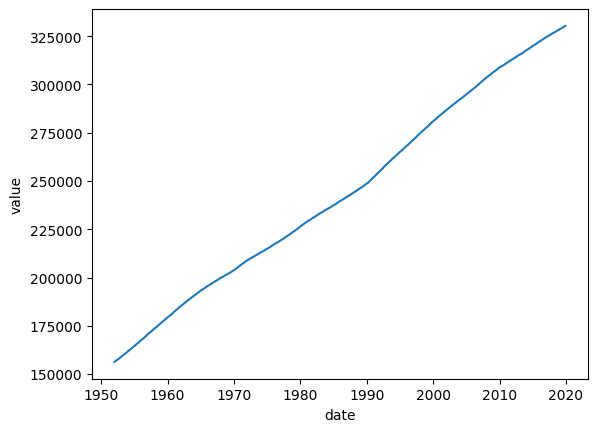

In [11]:
sns.lineplot(x='date', y='value', data=df_pop)
# change x axis to year, reduce the number of xticks
# plt.xticks(ticks=df_pop['date'].dt.year.unique())
plt.show()

### Linearity in data

since the data follows a linear trend, our forecasting would be quite robust

In [12]:
def create_window(target, window=1):
    feature_new, target_new = [], []
    target_np = target.to_numpy()

    for index in range(window, target.shape[0]):
        feature_new.append(target_np[index - window: index])
        target_new.append(target_np[index])

    return np.array(feature_new), np.array(target_new)

In [13]:
df_sort = df_pop.sort_values(by=['date'])
window = 5
feature, target = create_window(df_sort['value'], window=window)
print(feature[0])
print(target[0])
print(df_sort.head(6))

[156309. 156527. 156731. 156943. 157140.]
157343.0
  realtime_start     value       date realtime_end
0     2019-12-06  156309.0 1952-01-01   2019-12-06
1     2019-12-06  156527.0 1952-02-01   2019-12-06
2     2019-12-06  156731.0 1952-03-01   2019-12-06
3     2019-12-06  156943.0 1952-04-01   2019-12-06
4     2019-12-06  157140.0 1952-05-01   2019-12-06
5     2019-12-06  157343.0 1952-06-01   2019-12-06


### Explanation

We're using a window of first 5 values to predict the 6th value (2nd to 6th value is used for predicting the 7th value and so on)

In [14]:
from sklearn.preprocessing import StandardScaler

We need to scale the values in our feature list to unit variance. this is done using the StandardScaler() function from sklearn which is fitted on the training data and then used to transform the test data

In [15]:
scaler_feature = StandardScaler()
feature_shape = feature.shape
feature_scaled = scaler_feature.fit_transform(feature)

scaler_target = StandardScaler()
target_scaled = scaler_target.fit_transform(target.reshape(-1,1))

In [16]:
def train_test_inorder(feature, target, perc_train = 0.8):
    size_train = int(len(feature) * perc_train)

    x_train = feature[0:size_train]
    y_train = target[0:size_train]

    x_test = feature[size_train: len(feature)]
    y_test = target[size_train: len(feature)]

    return x_train, x_test, y_train, y_test

In [17]:
x_train, x_test, y_train, y_test = train_test_inorder(feature_scaled, target_scaled)

Text(0.5, 0, 'Date')

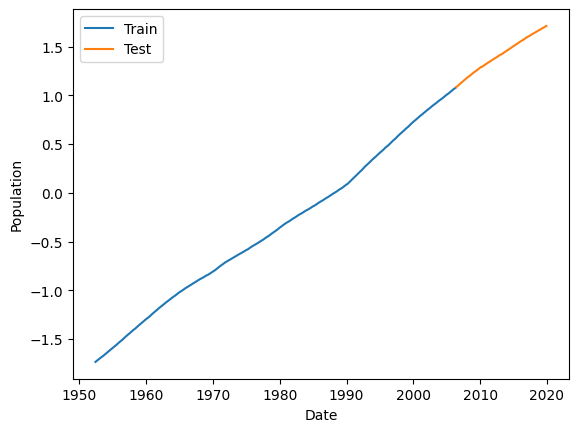

In [18]:
sns.lineplot(x=df_sort['date'].iloc[window:len(y_train) + window], y=y_train[:,0], label='Train')
sns.lineplot(x=df_sort['date'].iloc[len(y_train) + window:], y=y_test[:,0], label='Test')
plt.ylabel('Population')
plt.xlabel('Date')

### Linear regression

Since the data follows a linear trend, we can use linear regression to predict the values

In [19]:
def plot_fig(y_predicted, y_test, y_train, x_date, window):
    grid = plt.figure(figsize=(17,20))

    g1 = grid.add_subplot(2,1,1)
    g2 = grid.add_subplot(2,1,2)

    sns.lineplot(x=x_date[window:len(y_train) + window], y=y_train[:,0], label='Train', ax=g1)
    sns.lineplot(x=x_date[len(y_train) + window:], y=y_test[:,0], label='Test', ax=g1)
    sns.lineplot(x=x_date[len(y_train) + window:], y=y_predicted[:,0], label='Predicted', ax=g1)
    g1.set_title('Train x Test x Predict')

    sns.lineplot(x=x_date[len(y_train) + window:], y=y_test[:,0], label='Test', ax=g2)
    sns.lineplot(x=x_date[len(y_train) + window:], y=y_predicted[:,0], label='Predicted', ax=g2)
    g2.set_title('Test x Predict')

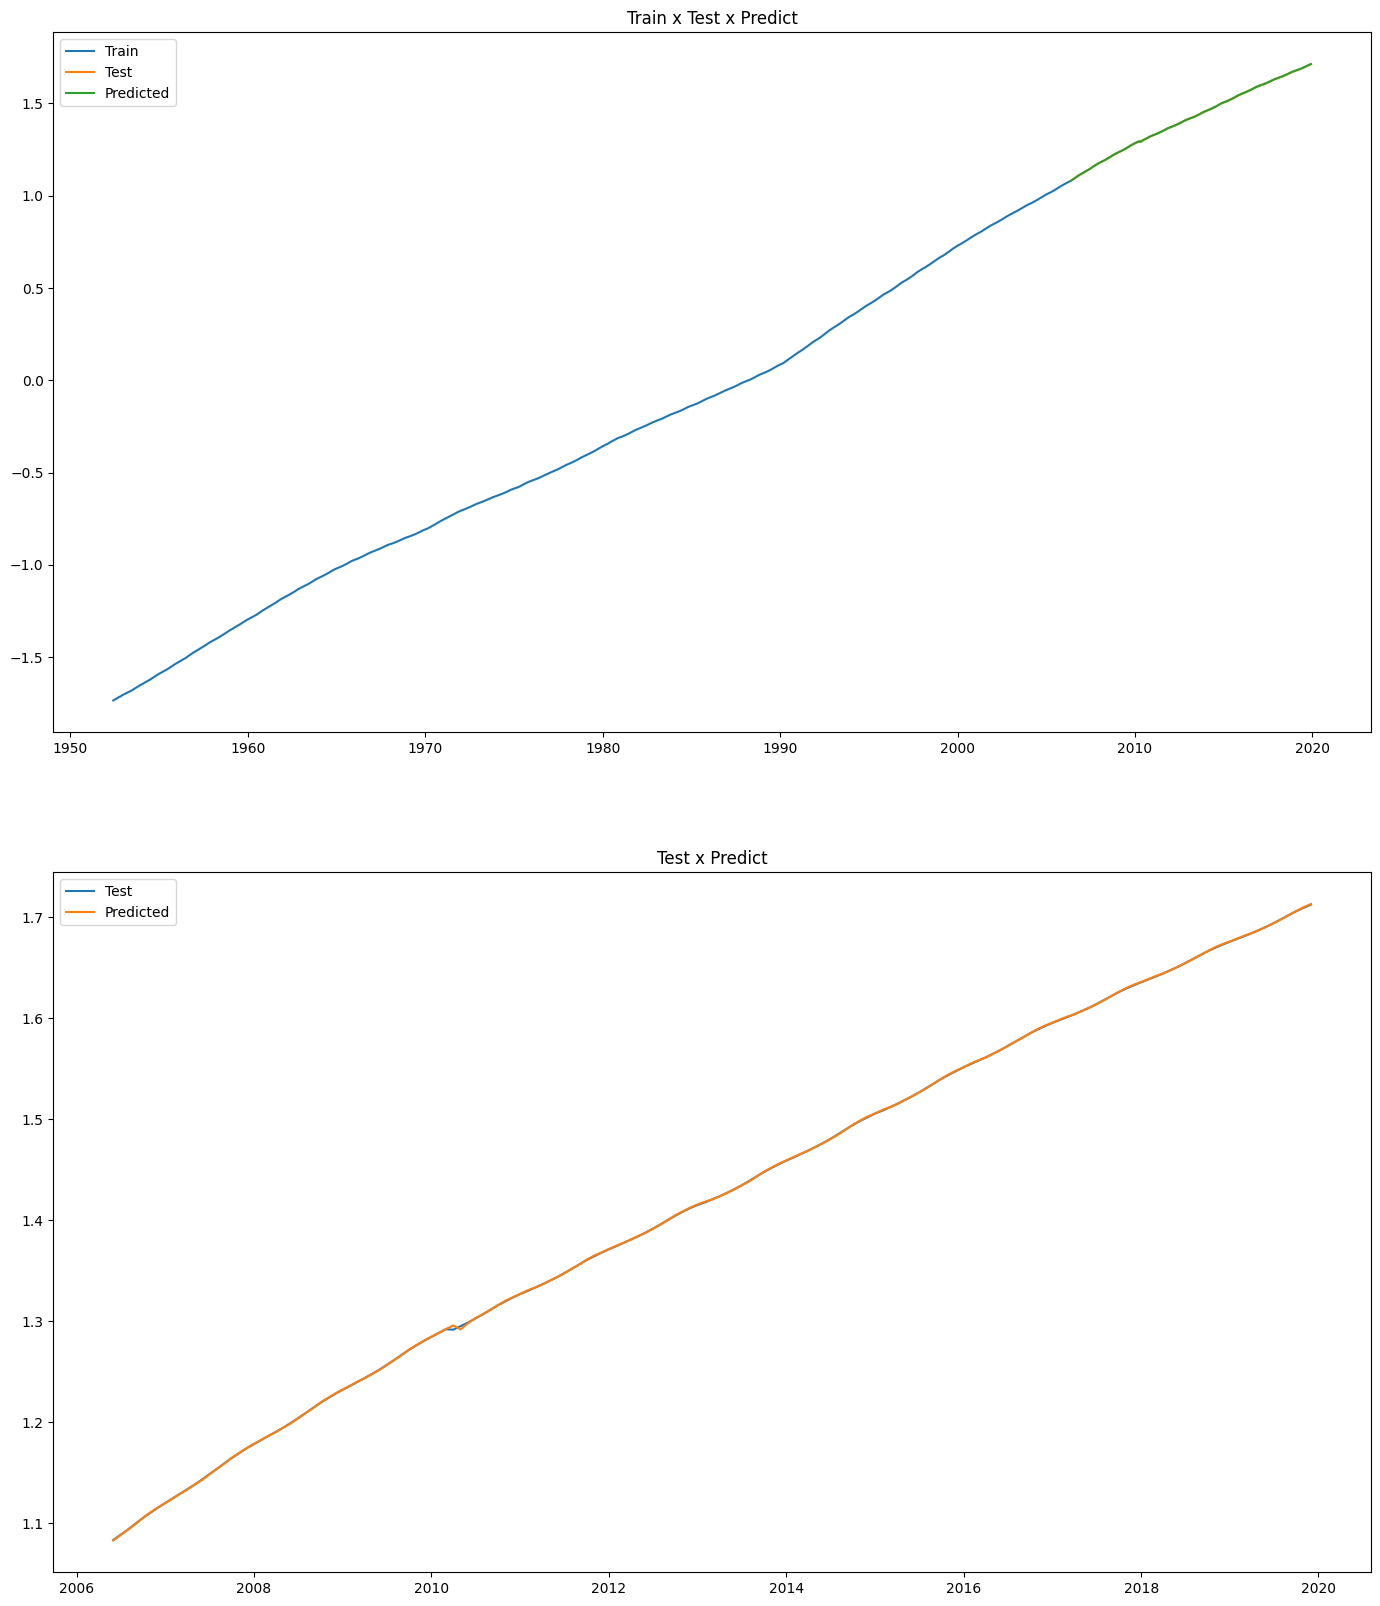

In [20]:
from sklearn.linear_model import LinearRegression

model_linear_reg = LinearRegression().fit(x_train.reshape(-1,window), y_train)
y_predicted = model_linear_reg.predict(x_test.reshape(-1,window))

plot_fig(y_predicted, y_test, y_train, df_sort['date'].to_numpy(), window)

In [21]:
# ARIMA model
from statsmodels.tsa.stattools import adfuller
from numpy import log

df = df_sort.copy()
result = adfuller(df.value.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


ADF Statistic: -0.665317
p-value: 0.855530


since the p value is greater than the alpha we chose (0.05), we can say that the data is not stationary

we now find the order of the AR and MA terms using the ACF and PACF plots

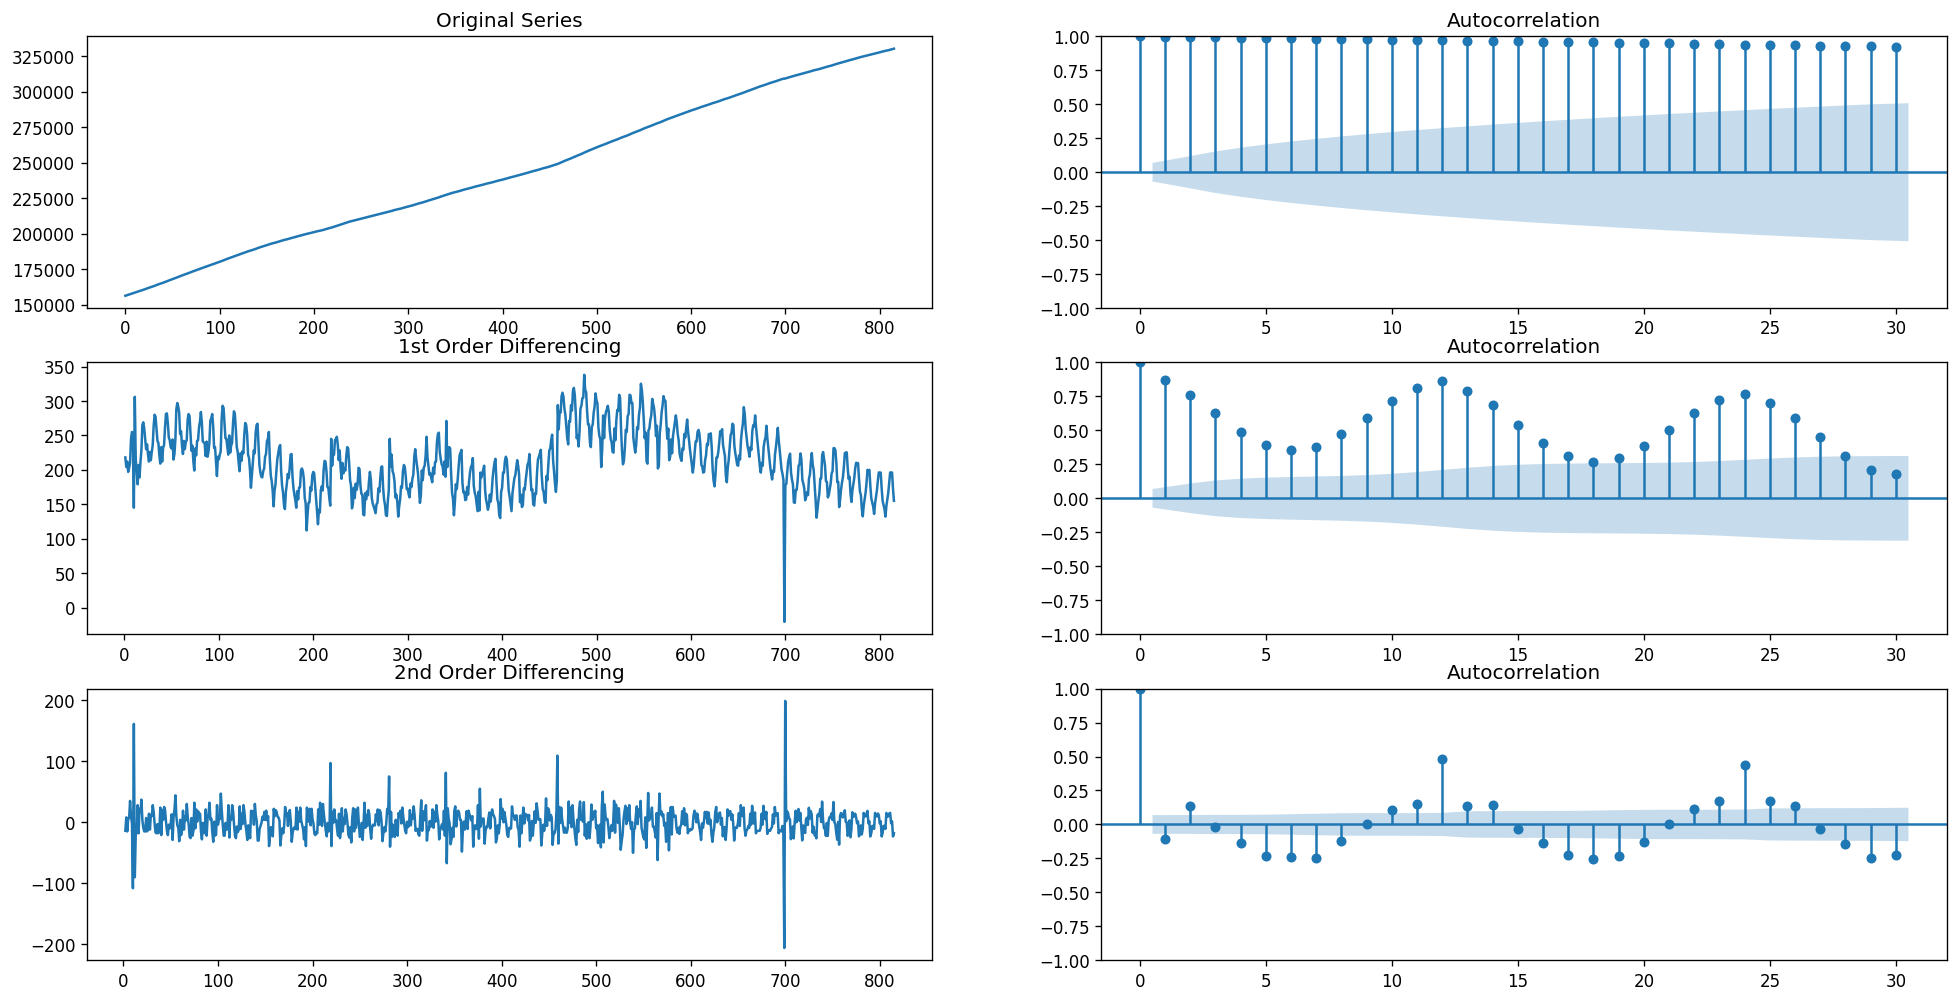

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(20,10), 'figure.dpi':120})


# Original Series
fig, axes = plt.subplots(3, 2, sharex=False)
axes[0, 0].plot(df.value)
axes[0, 0].set_title('Original Series')
plot_acf(df.value, ax=axes[0, 1], adjusted=True)

# 1st Differencing
axes[1, 0].plot(df.value.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.value.diff().dropna(), ax=axes[1, 1], adjusted=True)

# 2nd Differencing
axes[2, 0].plot(df.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.value.diff().diff().dropna(), ax=axes[2, 1], adjusted=True)

# chamge xlim for autocorrelation
plt.show()

For the above data, we can see that the time series reaches stationarity with two orders of differencing.

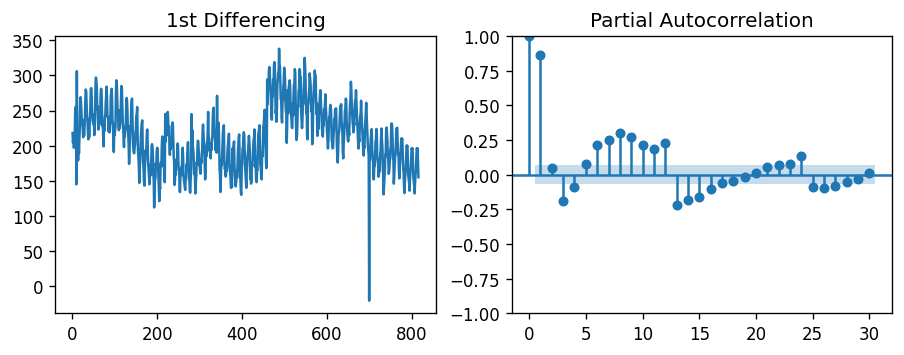

In [23]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.value.diff().dropna(), ax=axes[1], method='ywm')

plt.show()

We can see that the PACF lag 1 is quite significant since it is well above the significance line. So, we will fix the value of p as 1.

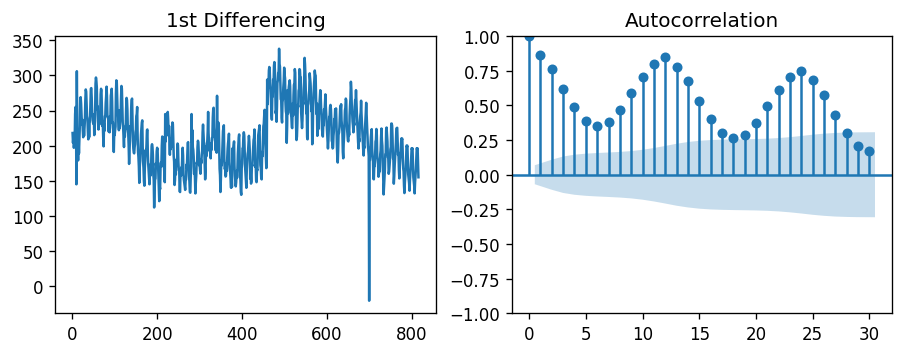

In [24]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.value.diff().dropna(), ax=axes[1])

plt.show()

We can see that couple of lags are well above the significance line. So, we will fix q as 2. If there is any doubt, we will go with the simpler model that sufficiently explains the Y.

we now build the model using the ARIMA function from statsmodels

In [25]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df.value, order=(1,1,2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  816
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -3760.407
Date:                Wed, 22 Nov 2023   AIC                           7528.814
Time:                        23:16:04   BIC                           7547.627
Sample:                             0   HQIC                          7536.035
                                - 816                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9973      0.001   1788.055      0.000       0.996       0.998
ma.L1         -0.3955      0.015    -25.526      0.000      -0.426      -0.365
ma.L2         -0.4524      0.021    -21.830      0.0

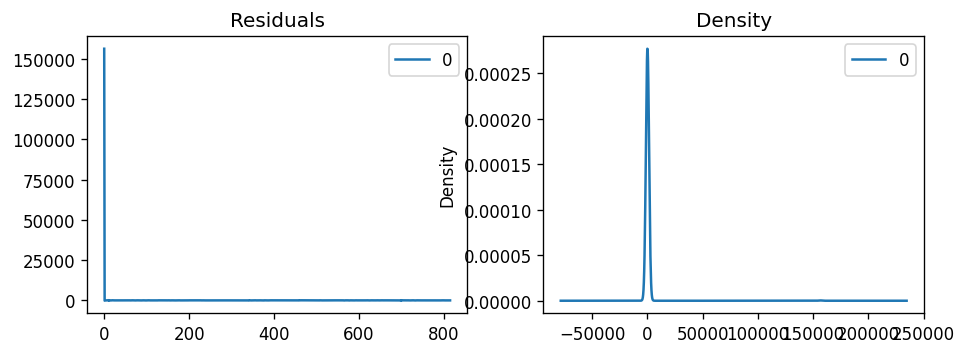

In [26]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [27]:
model = ARIMA(df.value, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  816
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3770.630
Date:                Wed, 22 Nov 2023   AIC                           7547.260
Time:                        23:16:05   BIC                           7561.370
Sample:                             0   HQIC                          7552.676
                                - 816                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9729      0.001    826.368      0.000       0.971       0.975
ma.L1         -0.1468      0.013    -11.151      0.000      -0.173      -0.121
sigma2       464.2493      8.251     56.266      0.0

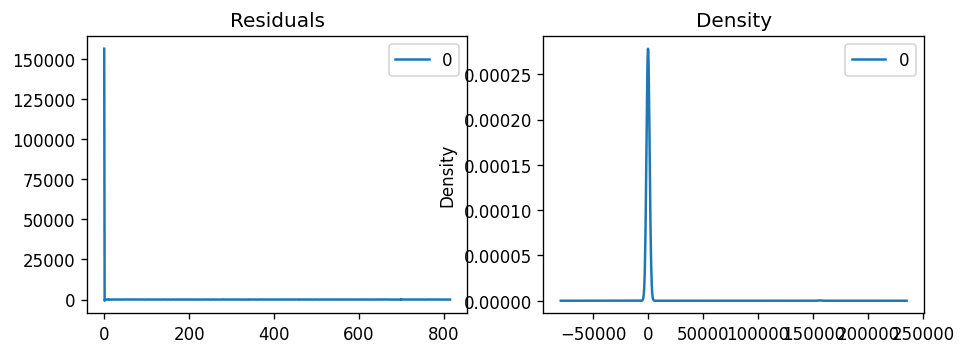

In [28]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

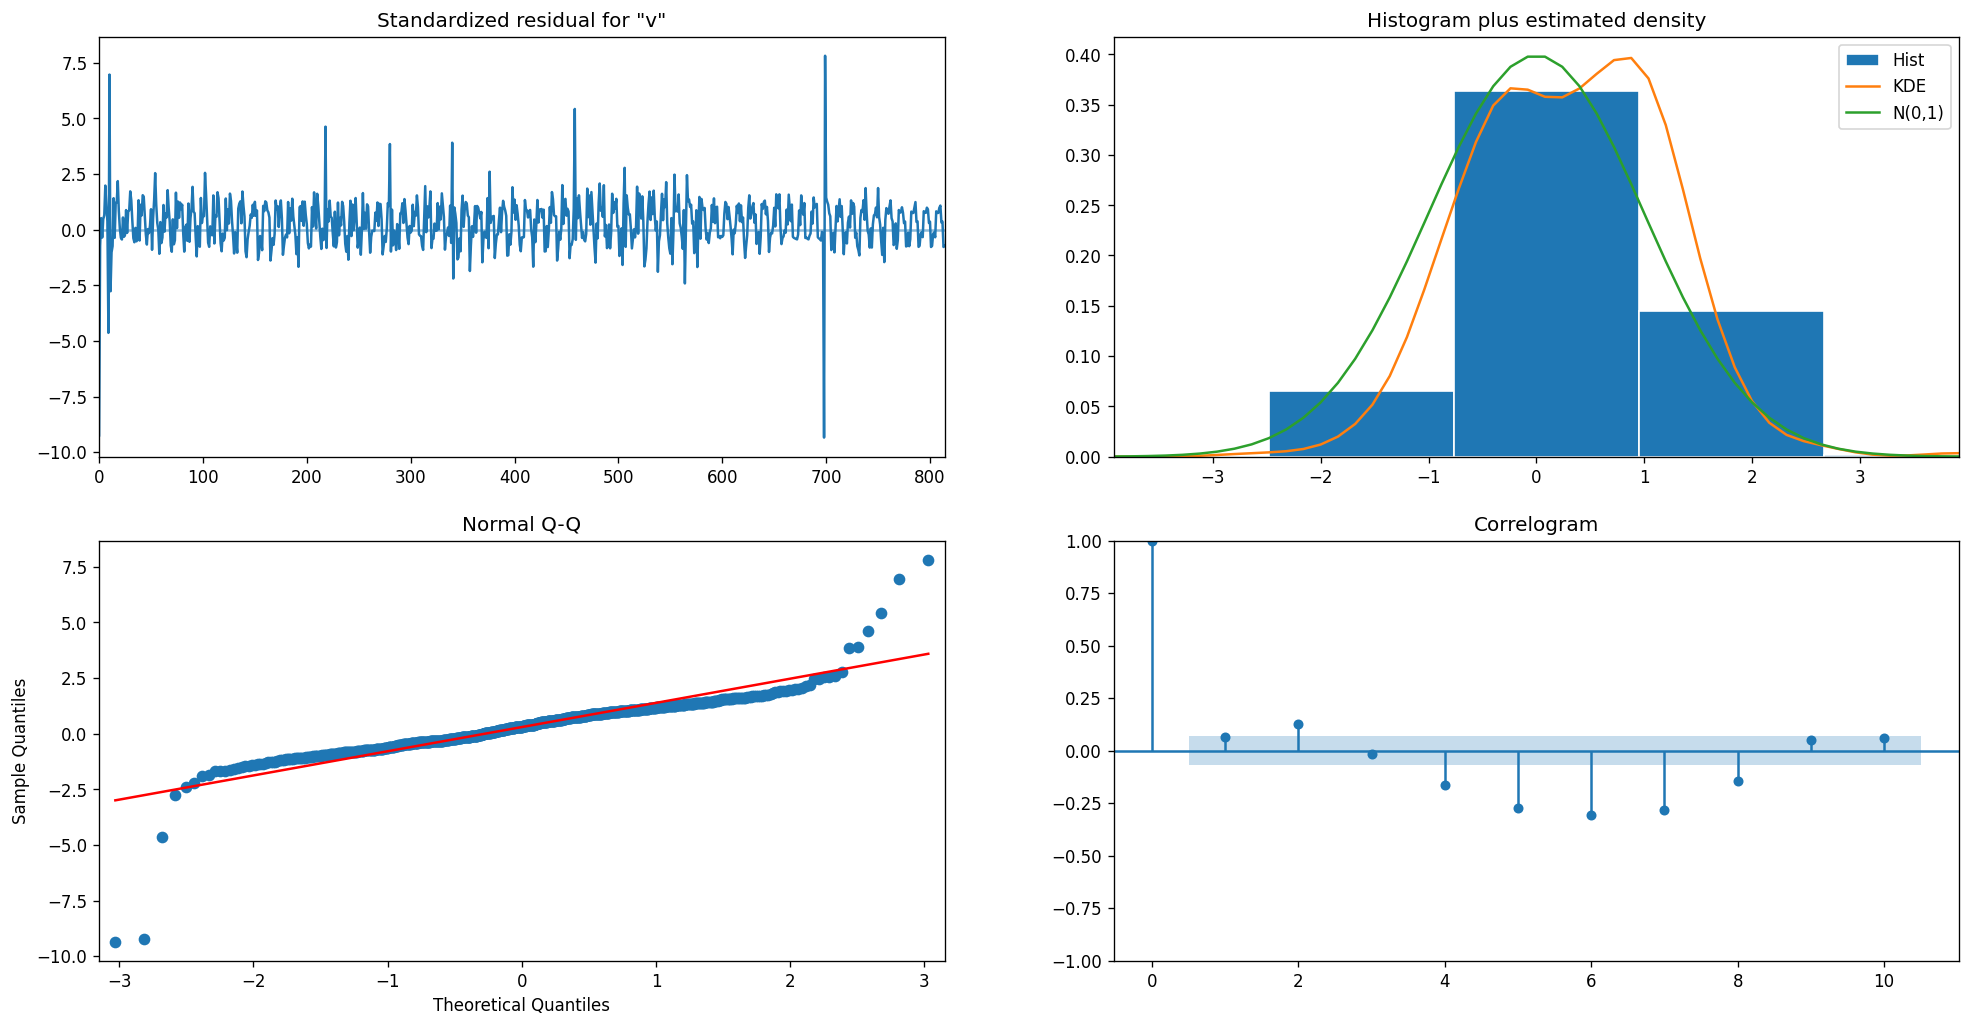

In [29]:
# Actual vs Fitted
model_fit.plot_diagnostics(figsize=(20,10))
plt.show()

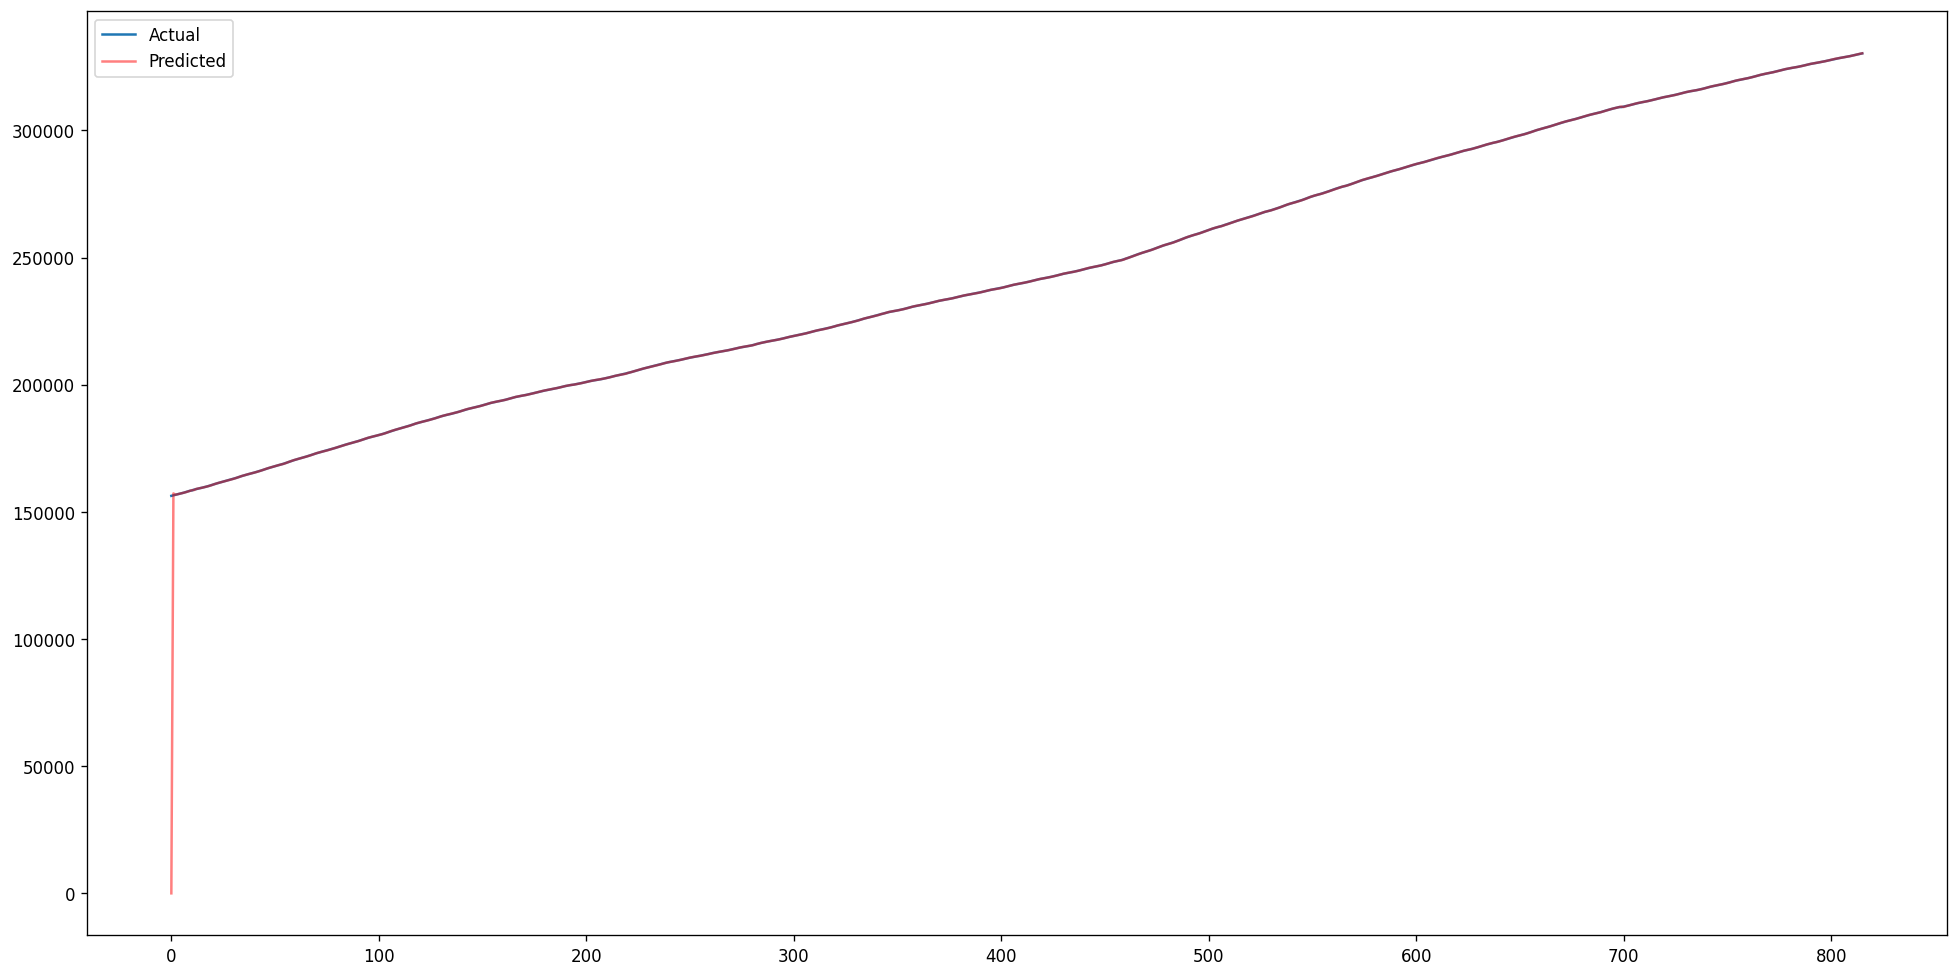

In [30]:
# plot the predicted vs actual
plt.figure(figsize=(20,10))
plt.plot(df.value, label='Actual')
plt.plot(model_fit.predict(), color='red', label='Predicted', alpha=0.5)
plt.legend()
plt.show()

/Users/krishanu/opt/anaconda3/envs/datavis/lib/python3.8/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


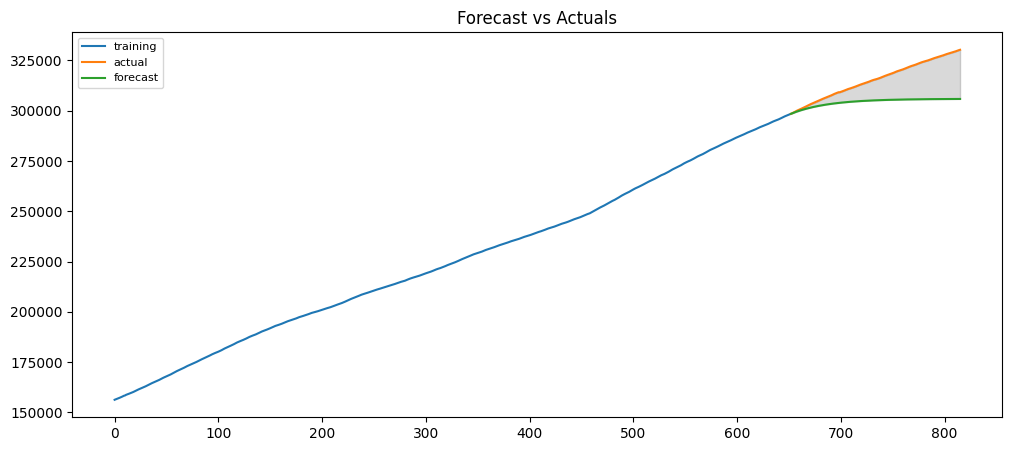

/Users/krishanu/opt/anaconda3/envs/datavis/lib/python3.8/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


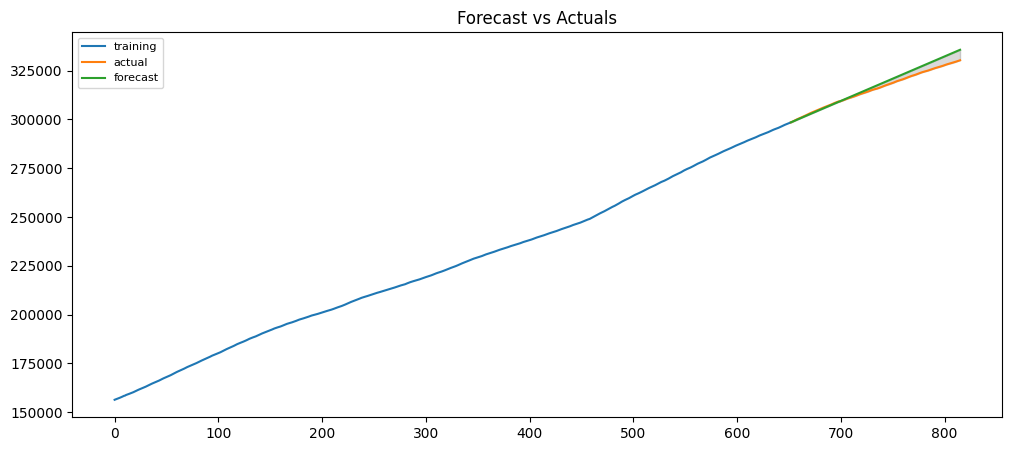

In [31]:
# train test split
size = int(len(df.value) * 0.8)
train, test = df.value[0:size], df.value[size:len(df.value)]

for model in [ARIMA(train, order=(1, 1, 1)), ARIMA(train, order=(3, 2, 1))]:
    fitted = model.fit()  

    # Forecast
    fc = fitted.forecast(164, alpha=0.05)  # 95% conf

    # Make as pandas series
    fc_series = pd.Series(fc, index=test.index)

    # Plot
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(train, label='training')
    plt.plot(test, label='actual')
    plt.plot(fc_series, label='forecast')

    plt.fill_between(fc_series.index, fc_series, test, 
                    color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()

In [32]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    forecast = np.array(forecast)
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax  
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)

{'mape': 0.00575712991748507,
 'me': 1696.180171343512,
 'mae': 1858.0739103280825,
 'mpe': 0.005225751182451962,
 'rmse': 2464.5213197418607,
 'acf1': 0.9839994560103859,
 'corr': 0.9989974619298464,
 'minmax': 0.005700730562861467}